In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting the data 
import seaborn as sns # Advanced data plotting on top of matplotlib
import os


from PIL import Image
import pickle

**About data and compitition**

*images* - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.

*articles.csv* - detailed metadata for each article_id available for purchase

*customers.csv* - metadata for each customer_id in dataset

*sample_submission.csv* - a sample submission file in the correct format

*transactions_train.csv* - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

*target*: Make predictions for all customer_id values found in the sample submission. All customers who made purchases during the test period are scored, regardless of whether they had purchase history in the training data.

Submissions are evaluated according to the Mean Average Precision @ 12 (MAP@12).
For each customer_id observed in the training data, you may predict up to 12 labels for the article_id, which is the predicted items a customer will buy in the next 7-day period after the training time period. 

# EDA

**Articles data**

In [2]:
articles_df = pd.read_csv("/kaggle/input/h-and-m-personalized-fashion-recommendations/articles.csv")
print(articles_df.shape)
articles_df.head().T  

(105542, 25)


,0,1,2,3,4
article_id,108775015,108775044,108775051,110065001,110065002
product_code,108775,108775,108775,110065,110065
prod_name,Strap top,Strap top,Strap top (1),OP T-shirt (Idro),OP T-shirt (Idro)
product_type_no,253,253,253,306,306
product_type_name,Vest top,Vest top,Vest top,Bra,Bra
product_group_name,Garment Upper body,Garment Upper body,Garment Upper body,Underwear,Underwear
graphical_appearance_no,1010016,1010016,1010017,1010016,1010016
graphical_appearance_name,Solid,Solid,Stripe,Solid,Solid
colour_group_code,9,10,11,9,10
colour_group_name,Black,White,Off White,Black,White


In [3]:
# Number of unique meanings of article features
for col in articles_df.columns:
    print(col, len(articles_df[col].unique()))
    

article_id 105542
product_code 47224
prod_name 45875
product_type_no 132
product_type_name 131
product_group_name 19
graphical_appearance_no 30
graphical_appearance_name 30
colour_group_code 50
colour_group_name 50
perceived_colour_value_id 8
perceived_colour_value_name 8
perceived_colour_master_id 20
perceived_colour_master_name 20
department_no 299
department_name 250
index_code 10
index_name 10
index_group_no 5
index_group_name 5
section_no 57
section_name 56
garment_group_no 21
garment_group_name 21
detail_desc 43405


In [4]:
articles_df.garment_group_name.value_counts().values

array([21445, 11519,  8126,  7490,  7441,  6727,  5838,  5145,  4874,
        4501,  3873,  3100,  2787,  2272,  2116,  1965,  1559,  1541,
        1254,  1061,   908])

Text(0.5, 1.0, 'Garment Group')

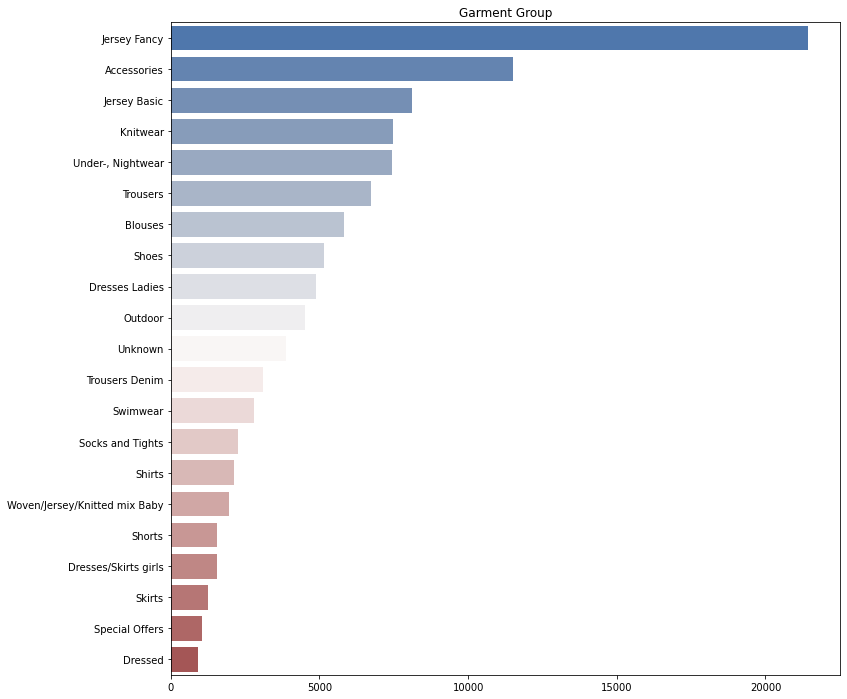

In [5]:
plt.figure(figsize=(12,12))
sns.barplot(y = articles_df.garment_group_name.value_counts().index, x=articles_df.garment_group_name.value_counts().values, palette="vlag")
plt.title("Garment Group", loc='center')

Text(0.5, 1.0, 'Index group')

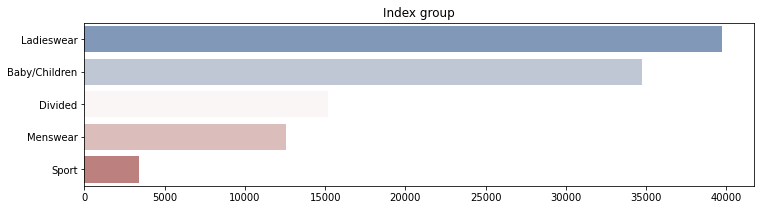

In [6]:
plt.figure(figsize=(12,3))
sns.barplot(y = articles_df.index_group_name.value_counts().index, x=articles_df.index_group_name.value_counts().values, palette="vlag")
plt.title("Index group", loc='center')

Text(0.5, 1.0, 'Index name')

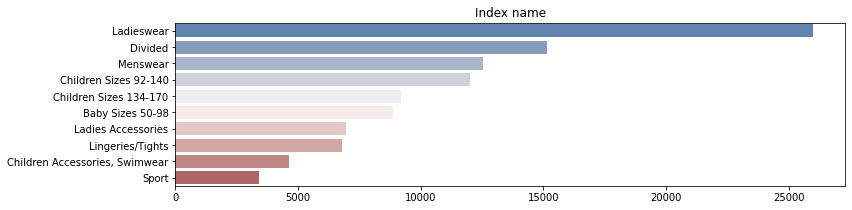

In [7]:
plt.figure(figsize=(12,3))
sns.barplot(y = articles_df.index_name.value_counts().index, x=articles_df.index_name.value_counts().values, palette="vlag")
plt.title("Index name", loc='center')

Text(0.5, 1.0, 'Index type')

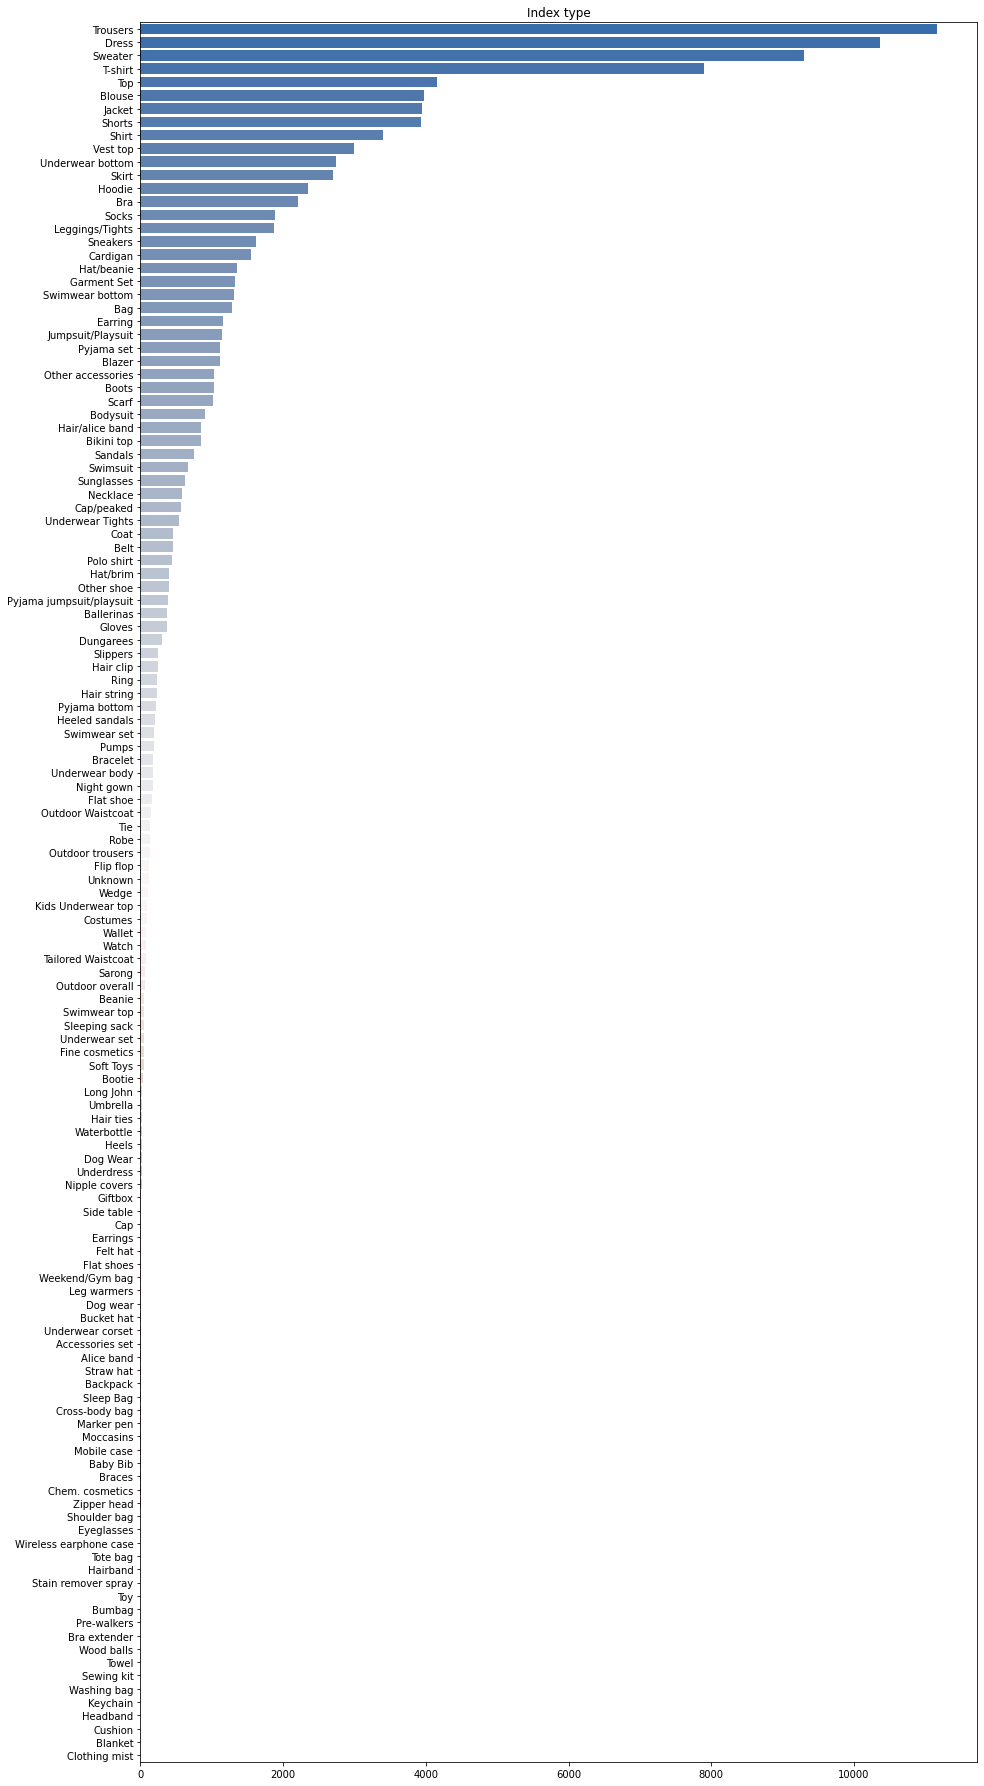

In [8]:
plt.figure(figsize=(15,32))
sns.barplot(y = articles_df.product_type_name.value_counts().index, x=articles_df.product_type_name.value_counts().values, palette="vlag")
plt.title("Index type", loc='center')

Text(0.5, 1.0, 'Product group')

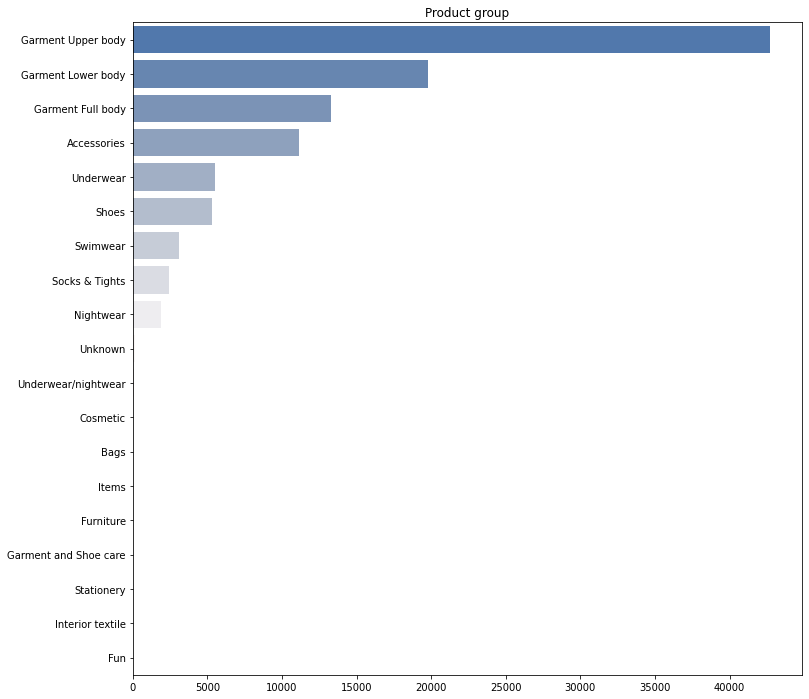

In [9]:
plt.figure(figsize=(12,12))
sns.barplot(y = articles_df.product_group_name.value_counts().index, x=articles_df.product_group_name.value_counts().values, palette="vlag")
plt.title("Product group", loc='center')

In [10]:
#text features
articles_detail_desc_len = articles_df.detail_desc.str.split().apply(lambda a: len(a) if type(a)==list else 1)
articles_detail_desc_len.describe()

count    105542.000000
mean         23.811923
std          11.688802
min           1.000000
25%          16.000000
50%          22.000000
75%          30.000000
max         121.000000
Name: detail_desc, dtype: float64

In [11]:
articles_df.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [12]:
articles_df.fillna("no data", inplace=True)

In [13]:
articles_df.iloc[0,:]

article_id                                                    108775015
product_code                                                     108775
prod_name                                                     Strap top
product_type_no                                                     253
product_type_name                                              Vest top
product_group_name                                   Garment Upper body
graphical_appearance_no                                         1010016
graphical_appearance_name                                         Solid
colour_group_code                                                     9
colour_group_name                                                 Black
perceived_colour_value_id                                             4
perceived_colour_value_name                                        Dark
perceived_colour_master_id                                            5
perceived_colour_master_name                                    

In [14]:
str_df = articles_df.apply(lambda a: a['prod_name'] + '[SEP]' +
                            a['product_group_name'] + '[SEP]' +
                            a['colour_group_name'] + '[SEP]' +
                            a['index_name'] + '[SEP]' +
                            a['section_name'] + '[SEP]' +
                            a['detail_desc'], axis=1)

In [15]:
articles_df.detail_desc

0                   Jersey top with narrow shoulder straps.
1                   Jersey top with narrow shoulder straps.
2                   Jersey top with narrow shoulder straps.
3         Microfibre T-shirt bra with underwired, moulde...
4         Microfibre T-shirt bra with underwired, moulde...
                                ...                        
105537    Socks in a fine-knit cotton blend with a small...
105538    Loose-fitting sports vest top in ribbed fast-d...
105539    Short, A-line dress in jersey with a round nec...
105540                             Large plastic hair claw.
105541    Calf-length dress in ribbed jersey made from a...
Name: detail_desc, Length: 105542, dtype: object

In [16]:
str_df

0         Strap top[SEP]Garment Upper body[SEP]Black[SEP...
1         Strap top[SEP]Garment Upper body[SEP]White[SEP...
2         Strap top (1)[SEP]Garment Upper body[SEP]Off W...
3         OP T-shirt (Idro)[SEP]Underwear[SEP]Black[SEP]...
4         OP T-shirt (Idro)[SEP]Underwear[SEP]White[SEP]...
                                ...                        
105537    5pk regular Placement1[SEP]Socks & Tights[SEP]...
105538    SPORT Malaga tank[SEP]Garment Upper body[SEP]B...
105539    Cartwheel dress[SEP]Garment Full body[SEP]Blac...
105540    CLAIRE HAIR CLAW[SEP]Accessories[SEP]Black[SEP...
105541    Lounge dress[SEP]Garment Full body[SEP]Off Whi...
Length: 105542, dtype: object

# Model

In [17]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 546.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=c503515990af227b729a0644603a0dc35d1a6d7c16953580a667a9f054f19b5a
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [18]:
load_files = False

In [19]:
from sentence_transformers import SentenceTransformer

if load_files:
    model = SentenceTransformer('sentence-transformers/LaBSE')

In [20]:
%%time

if load_files:
    
    embeddings = model.encode(articles_df.detail_desc)
    


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 20.3 µs


In [21]:
# save embedings
if load_files:
    with open('test_embedings', 'wb') as fp:
        pickle.dump(embeddings, fp)
else:
    with open('../input/h-m-recsys-nlp/test_embedings', 'rb') as fp:
        embeddings = pickle.load(fp)
       

In [22]:
print(embeddings.shape)

(105542, 768)


In [23]:
#embeddings[0]

In [24]:
def top_n_nearesst_index(embeddings, item_to_predict = 0, n = 5): 

    cs_list = []
    #print(embeddings[item_to_predict].reshape(1, -1))
    
    for item in embeddings:
        #cs = cosine_similarity(item.reshape(1, -1), embeddings[item_to_predict].reshape(1, -1))
        
        # np cosine_similarity works faster
        corrcoef = np.correlate(item, embeddings[item_to_predict])

        cs_list.append(corrcoef[0])
    
    
    argsort_scores_idx = np.argsort(cs_list)[-n-1:-1]
    argsort_scores_idx = np.flip(argsort_scores_idx)

    return argsort_scores_idx

In [25]:
pred_0 = top_n_nearesst_index(embeddings, 0, 12)

In [26]:
articles_df.iloc[pred_0, 0].values

array([108775044, 108775051, 623522005, 623522004, 623522003, 623522002,
       623522001, 623522010, 623522008, 702483005, 702483004, 702483002])

In [27]:
def make_image_path(image_id):
    return "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(image_id)[:2], image_id)

def draw_images(image_ids):
    img_list = []
    for id in image_ids:
        #image_path = "../input/h-and-m-personalized-fashion-recommendations/images/0{}/0{}.jpg".format(str(id)[:2], id)
        image_path = make_image_path(id)
        #print(image_path)
        
        try:
            img = Image.open(image_path)
        except FileNotFoundError:
            img = Image.new(mode="RGBA", size=(50,50), color="red") 
            
            
        img_list.append(img)

    plt.figure(figsize=(20,5))
    for j in range(len(image_ids)):
        plt.subplot(1, len(image_ids), j+1)
        plt.axis('off')
        plt.imshow(img_list[j])
        plt.title(str(image_ids[j]), loc='center')

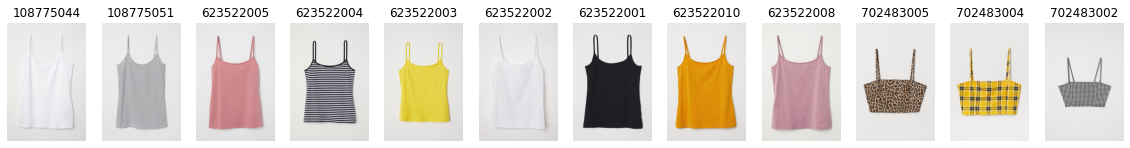

In [28]:
draw_images(articles_df.iloc[pred_0, 0].values)

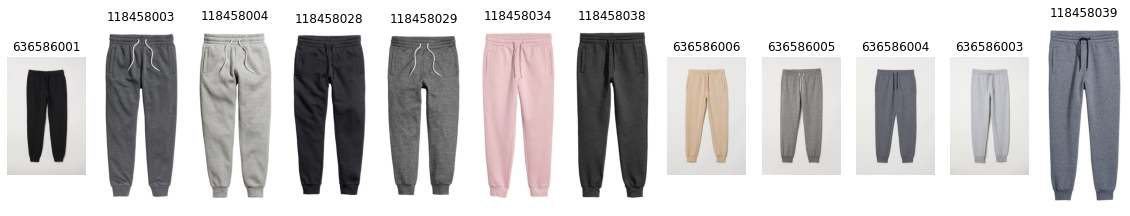

In [29]:
draw_images(articles_df.iloc[top_n_nearesst_index(embeddings, 20, 12), 0].values)

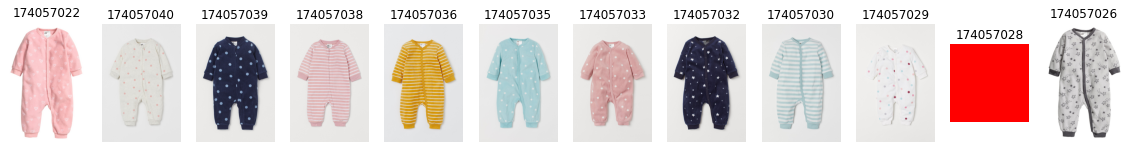

In [30]:
draw_images(articles_df.iloc[top_n_nearesst_index(embeddings, 90, 12), 0].values)

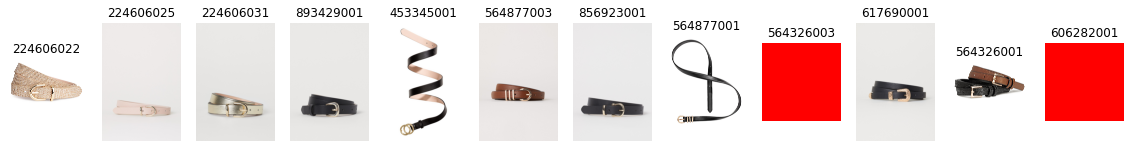

In [31]:
draw_images(articles_df.iloc[top_n_nearesst_index(embeddings, 350, 12), 0].values)

# Test

In [32]:
customer_test_df = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test.csv")
customer_test_df_hiden_transactions = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test_df_hiden_transactions.csv")
customer_test_df_open_transactions = pd.read_csv("../input/fork-of-h-m-recsys-eda-and-split/customer_test_df_open_transactions.csv")

customer_test_df.head()

,customer_id,article_id
0,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,30
1,001521e8394eb81ba43ab5b84ae7e756d51ac813be212a...,34
2,00294f5274dbc84408d60fc661860d385c2901dccca8c4...,48
3,002975c14a1aecac230ebf40c314fcad04ee3140e9bef2...,32
4,002e0bc901590e07341001b2358bded94031771537c24b...,21


In [33]:
full_pred_list = []

# go through all customers from test list
for k, customer in enumerate(customer_test_df.customer_id):
    
    
    # go through all purchases of customers
    customer_pred = []
    for id in customer_test_df_open_transactions[customer_test_df_open_transactions.customer_id == customer].article_id:
        
        # if no image for this id go next
        
        article_index = articles_df[articles_df.article_id == id].index.values[0]
        #print(article_index)
        
        if article_index > len(embeddings):
            continue
        
        # for every item predict 12 items
        article_index_pred = articles_df.iloc[top_n_nearesst_index(embeddings, article_index, 12), 0].values
        #print(article_index_pred)    
        customer_pred += list(article_index_pred)
        
        
        
    print(k, customer, len(customer_pred), len(np.unique(customer_pred)), np.unique(customer_pred)[:4])
        
    full_pred_list.append(np.unique(customer_pred))    
    
    
#print(full_pred_list[0])



with open('text_preds', 'wb') as fp:
    pickle.dump(full_pred_list, fp)

0 000aa7f0dc06cd7174389e76c9e132a67860c5f65f970699daccc14425ac31a8 216 103 [494291002 501820001 501820003 501820004]
1 001521e8394eb81ba43ab5b84ae7e756d51ac813be212a96e8779e0e42c029c0 264 120 [287645002 287645003 287645013 287645022]
2 00294f5274dbc84408d60fc661860d385c2901dccca8c4145cccb90d63ef2b82 432 348 [215324023 243613004 294008036 294008040]
3 002975c14a1aecac230ebf40c314fcad04ee3140e9bef259acc390c3fac257cb 240 200 [493814004 499885002 502186001 502186003]
4 002e0bc901590e07341001b2358bded94031771537c24b6a7805c9b82cc95a1a 108 100 [144993001 179208001 234421001 234421002]
5 0063a5fab642a52b80dcc5561b3a2ef5a06f13f2967a7a9ba7672d139969424c 168 156 [417687001 417687003 426013007 426013023]
6 00a5601e1e207751fefbfc0c00006454e20a571a2dbdd1241cc5149eb4791ab3 336 323 [395619001 395619009 395619012 395619013]
7 0162c0eacae80811a6b926cb3432888bc3f5fffb963b66f4d250b5e9682a7cf2 48 36 [536946001 537116001 537116004 537116009]
8 01a654dd9975ab239e1aacceb81dba8ca3a2208cfe3aef527648acb3178115ea

In [34]:
len(full_pred_list)

500

In [35]:
ground_truth_list = []

# go through all customers from test list
for k, customer in enumerate(customer_test_df.customer_id):
    ground_truth_list.append(np.array(
        customer_test_df_hiden_transactions[customer_test_df_hiden_transactions.customer_id == customer].article_id))
    
print(len(ground_truth_list))

500


In [36]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

def jaccard(actual, predicted):
    return np.mean([jaccard_similarity(a,b) for a,b in zip(actual, predicted)])

def dice_similarity(list1, list2):
    intersection = 2 * len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) 
    return float(intersection) / union

def dice(actual, predicted):
    return np.mean([dice_similarity(a,b) for a,b in zip(actual, predicted)])

def intersept(list1, list2):
    return np.sum([len(list(set(a).intersection(b))) for a,b in zip(list1, list2)])

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    #if not actual:
    #    return 0.0

    return score / min(len(actual), k)


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])



def metrics(ground_truth, mp_preds):
    mp_interception = intersept(ground_truth_list, mp_preds)
    mp_jaccard_similarity = jaccard(ground_truth_list, mp_preds)
    mp_dice = dice(ground_truth_list, mp_preds)    
    mp_maok12 = mapk(ground_truth_list, mp_preds, 12)

    print("Interceptions: {} from {} ({:.4}%)".format(mp_interception, len(ground_truth) * 12, mp_interception*100/(len(ground_truth) * 12)) )
    print("Jaccard: {:.4}".format(mp_jaccard_similarity))
    print("Dice: {:.4}".format(mp_dice))
    print("Mean Average Precision @ 12: {:.4}".format(mp_maok12))
    
    return [mp_interception, mp_interception*100/(len(ground_truth) * 12), mp_jaccard_similarity, mp_dice, mp_maok12]

In [37]:
# 100 most popular items results
nlp_preds = full_pred_list

nlp_metrics =  metrics(ground_truth_list, nlp_preds)

Interceptions: 542 from 6000 (9.033%)
Jaccard: 0.01378
Dice: 0.02662
Mean Average Precision @ 12: 0.006861


In [38]:
mp_preds_12 = [item[:12] for item in full_pred_list]

nlp12_metrics = metrics(ground_truth_list, mp_preds_12)

Interceptions: 136 from 6000 (2.267%)
Jaccard: 0.01411
Dice: 0.02628
Mean Average Precision @ 12: 0.006861
